<IPython.core.display.Javascript object>


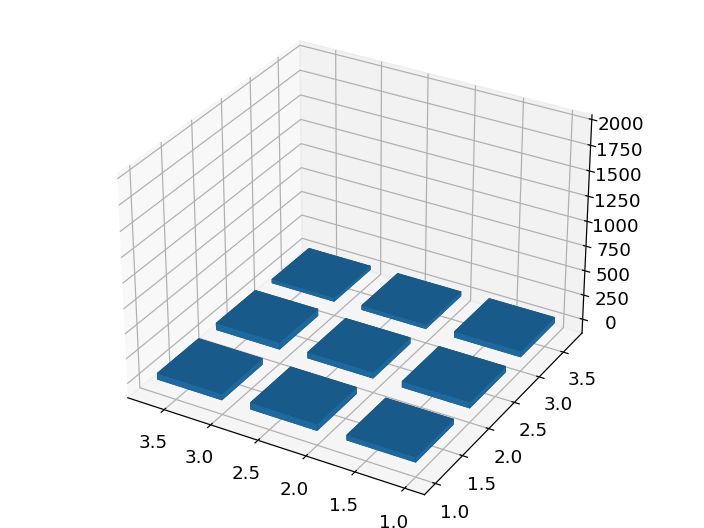

In [9]:
import serial        # install "pyserial" instead of "serial"
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 12

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

def read_sensor(N=3, timeout=0.5):
    
    '''
    Read raw data of N Hall sensor array ()
    :param N: the number of the whole sensor array
    :return: 3-axis magnetic flux densities of Nx9 Hall sensors (dim = 3 x N x 9)
    '''
    
    t_wait = 0
    res_x = 0.25; res_y = 0.25; res_z = 0.403
    bx, by, bz = np.zeros((N,9)), np.zeros((N,9)), np.zeros((N,9))
    
    data = s_my.readline().split()
    while len(data)!=N*3*9 or data[0]==0:
        t1 = time.time()
#         print(data)
        data = s_my.readline().split()
        t2 = time.time()
        t_wait = t_wait + (t2 - t1)
        if t_wait > timeout:
#             print('Timeout!')
            return np.array([bx,by,bz])
    
    for n in range(N):
        for i in range(9):
            bx[n][i] = res_x*int(data[0+i*3+n*27])
            by[n][i] = res_y*int(data[1+i*3+n*27])
            bz[n][i] = res_z*int(data[2+i*3+n*27])
            
    data_assembly = np.array([bx,by,bz])
            
    return data_assembly   # dim = 3 x N x 9 (3-axial magnetic flux densities of N sensor array, each with 9 Hall sensors)

def initialize_sensor(serial_port='/dev/ttyACM1'):
        
    '''
    Connect the sensor to the PC and initialize the sensor
    :param serial_port: for Windows --> enter port number 'COM#'
                        for Linux --> enter port number '/dev/ttyS#' and enable the serial port in command line
                        with command "sudo chmod 666 /dev/ttyS#" befor opening the port
                        （Tips: you can check serial devices on you PC with command "dmesg | grep ttyS*"）
    :return: the initial sensor readings (dim = 3 x N x 9)
    '''
    
    global s_my
    
    t = 0
    s_my = serial.Serial(serial_port, 115200, timeout=0.1)
    time.sleep(2)
    s_my.reset_input_buffer()

    while True:
        t1 = time.time()
        data_initial = read_sensor()     # the initial readings of the sensor (when not loaded)
        t2 = time.time()
        t = t + (t2 - t1)
        if data_initial[0][0][0] == 0:
            if t < 3:
                continue
            elif t >= 3:
                print("Timeout! Resetting the serial port...")
                s_my.close()
                time.sleep(1)
                s_my = serial.Serial(serial_port, 115200, timeout=0.1)
                time.sleep(1)
                if read_sensor()[0][0][0] != 0:
                    t = 0
                    continue
                else:
                    print("Failed to reset, please reconnect the arduino and the PC (replug the USB cable)!")
                    break

        elif data_initial[0][0][0] != 0 and t >= 3:
            break

    return data_initial   

def bar_plot(ax1,data):
    
    x = [1,2,3,1,2,3,1,2,3]
    y = [1,1,1,2,2,2,3,3,3]
    z = [0,0,0,0,0,0,0,0,0]
    dx = [0.7 for i in range(9)]
    dy = [0.7 for i in range(9)]
    
    dz = data
    ax1.cla()
    ax1.bar3d(x,y,z,dx,dy,dz,color='C0',shade=True)
    ax1.set_zlim(-100,2000)      # change this bound when necessary (according to the plot requirement)
    ax1.set_title('Magnetic flux density B (uT)')
    ax1.invert_yaxis()
    fig.canvas.draw()
    
t = 0
fig = plt.figure()
ax1 = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax1)


data_initial = initialize_sensor(serial_port = '/dev/ttyACM1')   # it takes ~5 seconds to initialize the sensor

        
while t < 15:           # modify the plot time t when necessary
    t_start = time.time()
    d = read_sensor() - data_initial        # remove the initial sensor readings from the original ones
#     d = read_sensor()         # directly use the original sensor readings
    
    bx_s1 = d[0][0]; bx_s2 = d[0][1]; bx_s3 = d[0][2]
    by_s1 = d[1][0]; by_s2 = d[1][1]; by_s3 = d[1][2]
    bz_s1 = d[2][0]; bz_s2 = d[2][1]; bz_s3 = d[2][2]

    # overall magnetic flux density B
    B1 = [np.sqrt(bx_s1[i]**2+by_s1[i]**2+bz_s1[i]**2) for i in range(9)]
    B2 = [np.sqrt(bx_s2[i]**2+by_s2[i]**2+bz_s2[i]**2) for i in range(9)]
    B3 = [np.sqrt(bx_s3[i]**2+by_s3[i]**2+bz_s3[i]**2) for i in range(9)]

#     bar_plot(ax1,bz_s1)    # plot magnetic flux density along z-axis
#     bar_plot(ax1,bx_s1)    # plot magnetic flux density along x-axis
#     bar_plot(ax1,by_s1)    # plot magnetic flux density along y-axis
    bar_plot(ax1,B1)     # plot overall magnetic flux density
    
    
    t_end = time.time()
    t = t + (t_end - t_start)
    
s_my.close()

In [6]:
s_my.close()